In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import eli5


from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
df_train = pd.read_csv("/kaggle/input/playground-series-s3e20/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s3e20/test.csv")

In [3]:
# Get idxs for submission

test_idxs = df_test['ID_LAT_LON_YEAR_WEEK']
df_test = df_test.drop(columns=['ID_LAT_LON_YEAR_WEEK'], axis=1)

In [4]:
df_train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [5]:
print("Train shape: {}, Test shape: {}".format(df_train.shape, df_test.shape))

Train shape: (79023, 76), Test shape: (24353, 74)


In [6]:
df_train.dtypes

ID_LAT_LON_YEAR_WEEK           object
latitude                      float64
longitude                     float64
year                            int64
week_no                         int64
                               ...   
Cloud_sensor_azimuth_angle    float64
Cloud_sensor_zenith_angle     float64
Cloud_solar_azimuth_angle     float64
Cloud_solar_zenith_angle      float64
emission                      float64
Length: 76, dtype: object

In [7]:
df_train.dtypes.groupby(df_train.dtypes).size().reset_index(name="Count")

,index,Count
0,int64,2
1,float64,73
2,object,1


### Fill NaNs with median value

In [8]:
print("Train NaNs: {}, Test NaNs: {}".format(df_train.isna().sum().sum(), df_test.isna().sum().sum()))

Train NaNs: 990091, Test NaNs: 320829


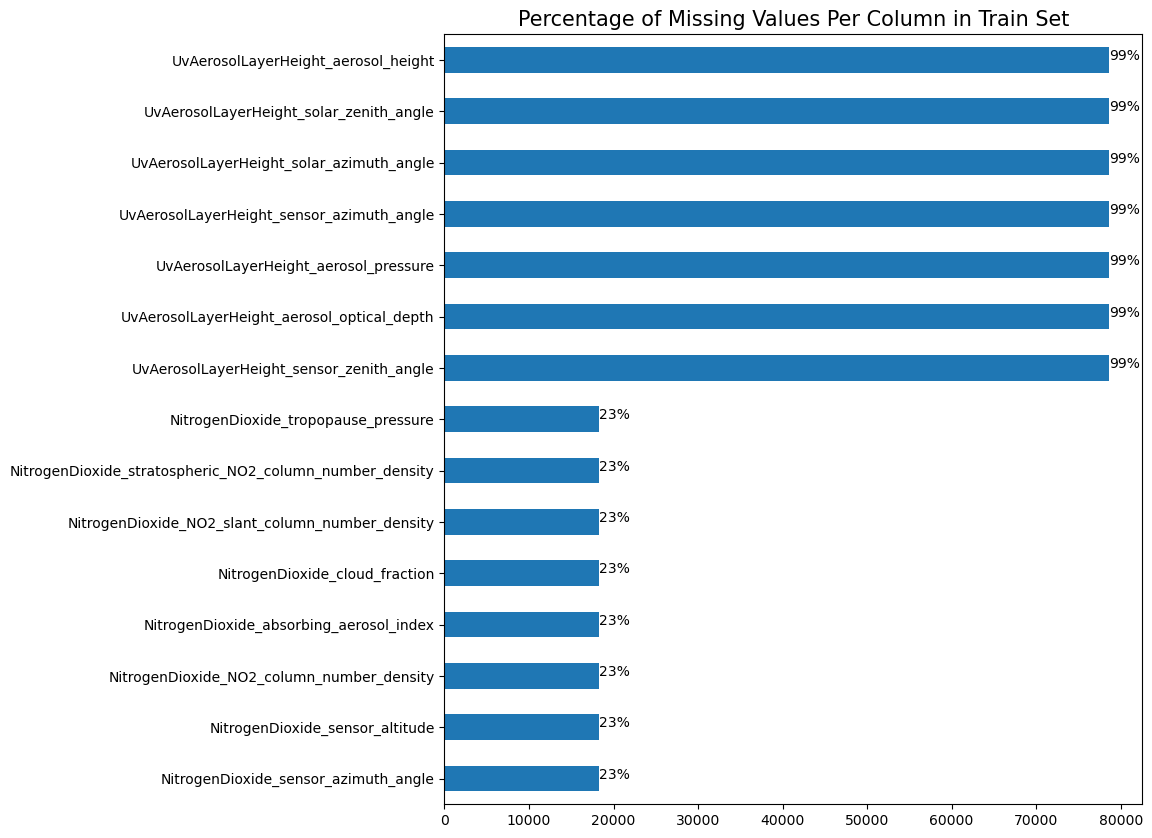

In [9]:
# From https://www.kaggle.com/code/inversion/getting-started-eda#4.-Outliers

ax = df_train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/df_train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

### Delete features that missing >90% of data

In [10]:
nan_threshold = 0.9
percentage_miss = df_train.isnull().mean()

columns_to_drop = percentage_miss[percentage_miss > nan_threshold].index

df_train = df_train.drop(columns_to_drop, axis=1)
df_test = df_test.drop(columns_to_drop, axis=1)

In [11]:
nan_columns = df_train.columns[df_train.isna().any()].tolist()

for nan_col in nan_columns:
    df_train[nan_col] = df_train[nan_col].fillna(df_train[nan_col].median())
    df_test[nan_col] = df_test[nan_col].fillna(df_test[nan_col].median())

In [12]:
print("Data after NaN processing")
print("Train NaNs: {}, Test NaNs: {}".format(df_train.isna().sum().sum(), df_test.isna().sum().sum()))

Data after NaN processing
Train NaNs: 0, Test NaNs: 0


### Explore target feature

<Axes: xlabel='emission', ylabel='Count'>

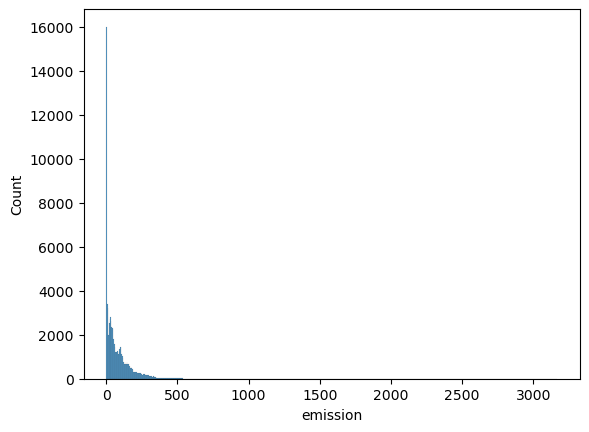

In [13]:
sns.histplot(df_train['emission'])

In [14]:
# df_train['emission'] = np.log(df_train['emission'] + 1e-7)

In [15]:
# sns.histplot(df_train['emission'])

## Pearson Correlation to remove highly correlated features

In [16]:
correlation_threshold = 0.7

In [17]:
df_corr = df_train.drop(columns = ['ID_LAT_LON_YEAR_WEEK', 'emission'], axis = 1)
corr_matrix = df_corr.corr()
corr_matrix = corr_matrix[abs(corr_matrix) >= correlation_threshold]

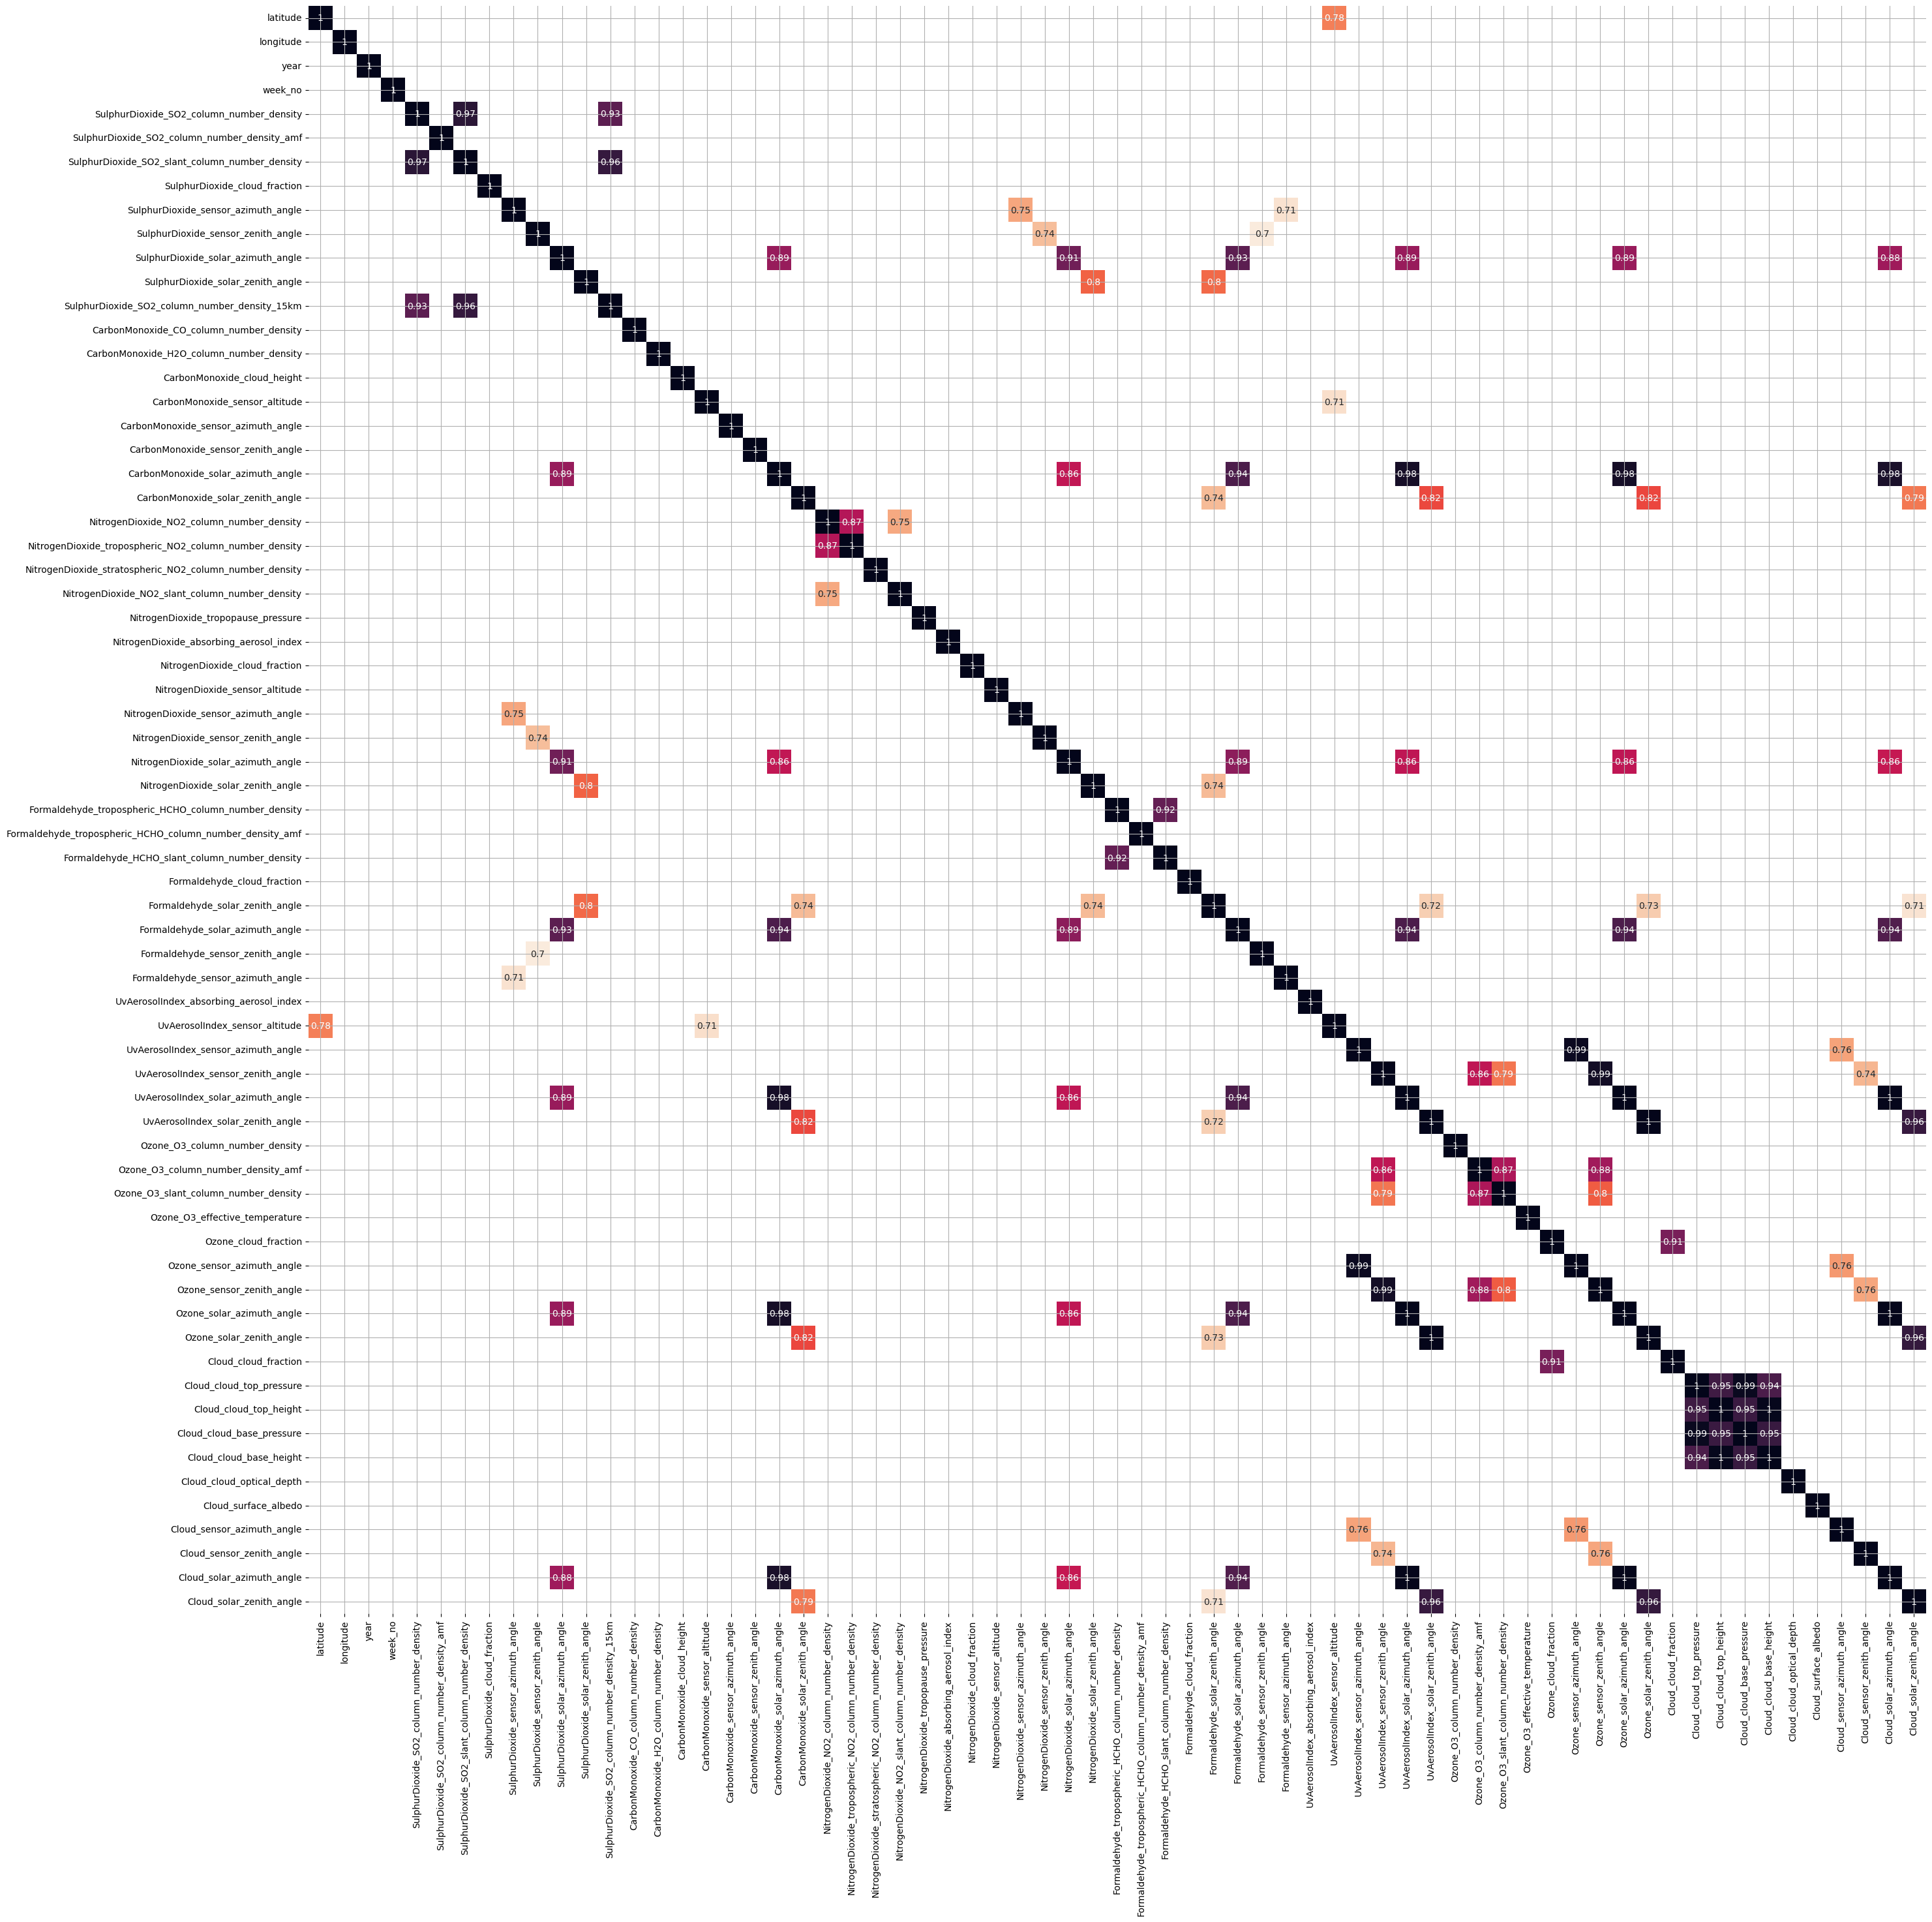

In [18]:
plt.figure(figsize=(32,32))
sns.heatmap(abs(corr_matrix), annot = True, cmap='rocket_r', cbar = False)
plt.grid()
plt.show()

In [19]:
corr_columns = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] >= correlation_threshold:
            colname = corr_matrix.columns[i]
            corr_columns.add(colname)

In [20]:
len(corr_columns)

30

In [21]:
df_train = df_train.drop(corr_columns, axis=1)
df_test = df_test.drop(corr_columns, axis=1)

In [22]:
print("Train shape: {}, Test shape: {}".format(df_train.shape, df_test.shape))

Train shape: (79023, 39), Test shape: (24353, 37)


In [23]:
df_train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,0.255668,-98.593887,50.843559,...,-12.628979,35.632416,0.115927,225.731144,0.595473,53534.732422,3664.436218,15.568533,0.272292,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.130988,16.592861,39.137194,...,16.152492,43.485327,0.116775,226.172170,0.175166,63790.296241,3651.190311,8.690601,0.256830,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.110018,72.795837,52.868816,...,-41.557633,41.269033,0.117039,227.469292,0.606091,55923.790554,4216.986492,21.103410,0.251101,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,0.000024,0.809118,0.161855,-12.441726,37.784299,...,-0.001270,34.458740,0.116434,225.589440,0.787398,44569.130636,5228.507736,15.386899,0.262043,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,0.121164,4.121269,35.515587,...,-0.604325,41.794705,0.117373,228.955840,0.215739,59904.314844,3980.598120,8.114694,0.235847,4.347317


### Plot new heatmap with removed features

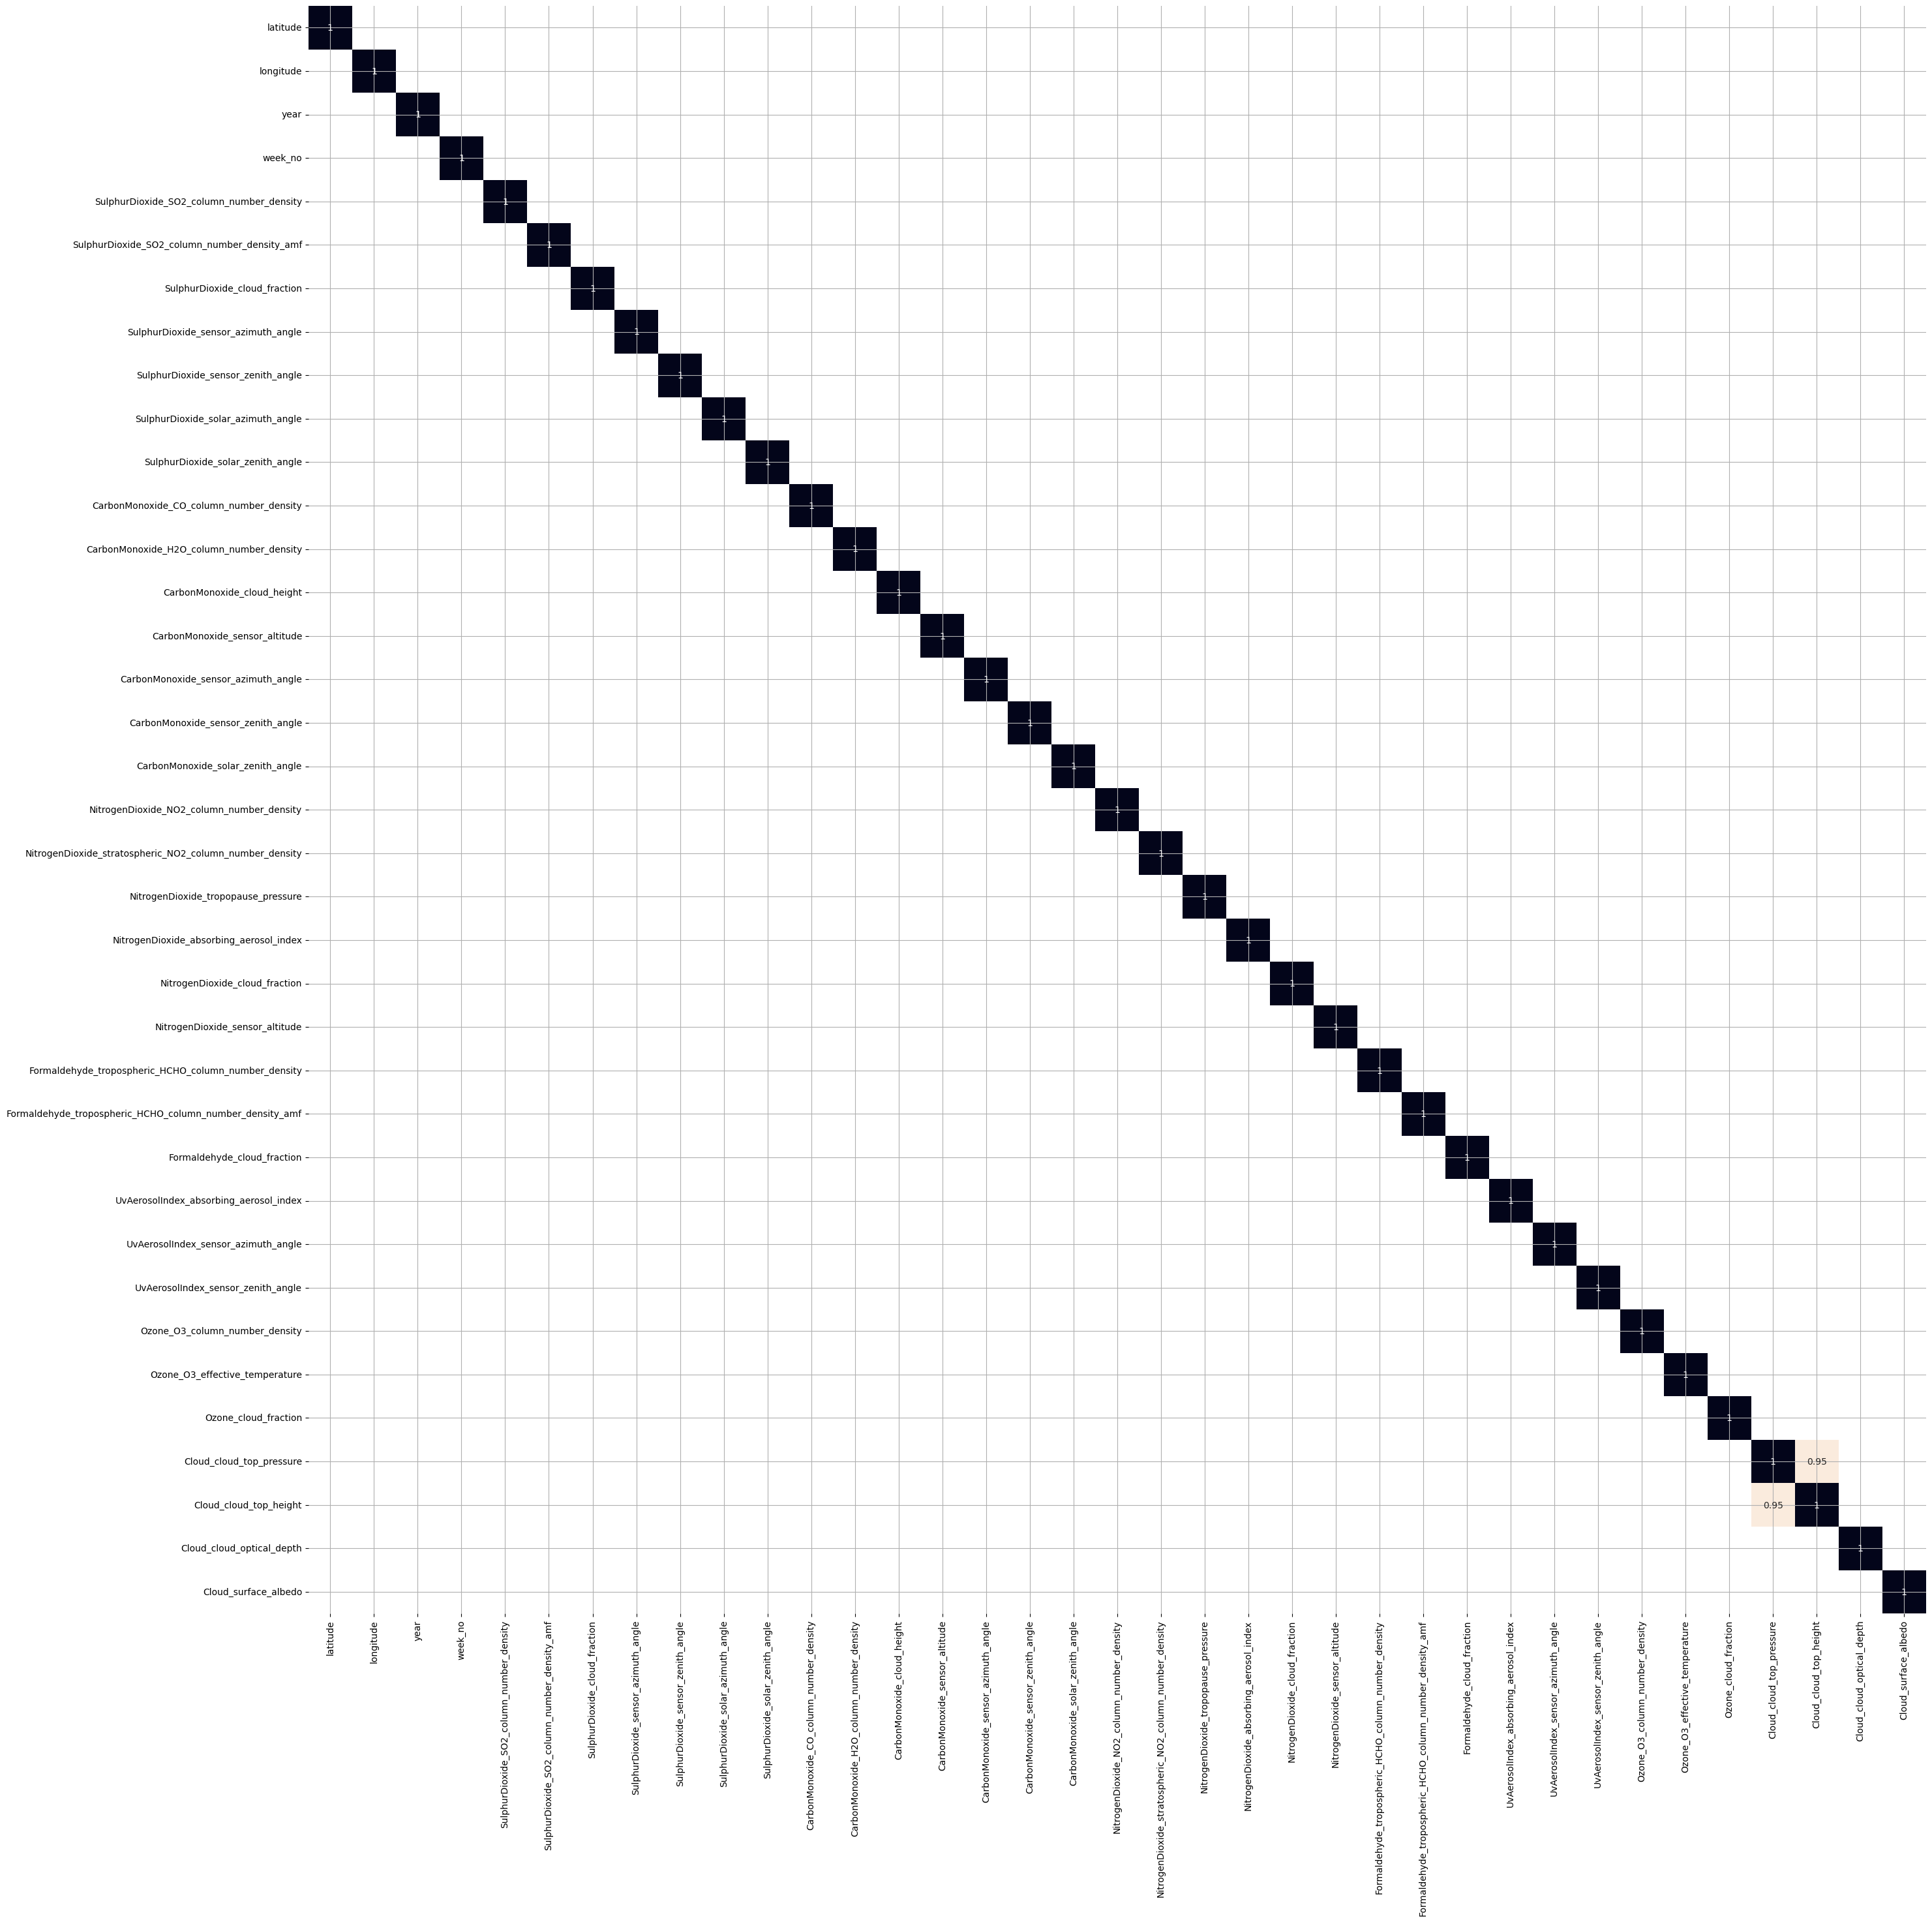

In [24]:
df_corr = df_train.drop(columns = ['ID_LAT_LON_YEAR_WEEK', 'emission'], axis = 1)
corr_matrix = df_corr.corr()
corr_matrix = corr_matrix[abs(corr_matrix) >= correlation_threshold]

plt.figure(figsize=(32,32))
sns.heatmap(abs(corr_matrix), annot = True, cmap='rocket_r', cbar = False)
plt.grid()
plt.show()

### Feature engineering and exploring of date features

In [25]:
# From https://www.kaggle.com/code/kacperrabczewski/rwanda-co2-step-by-step-guide#Feature-engineering-%F0%9F%9B%A0%EF%B8%8F

def create_date_feature(df):
    df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['week_no'].astype(str) + '-1', format='%Y-%W-%w')
    
    return df

df_train = create_date_feature(df_train)
df_test = create_date_feature(df_test)

<Axes: xlabel='Date'>

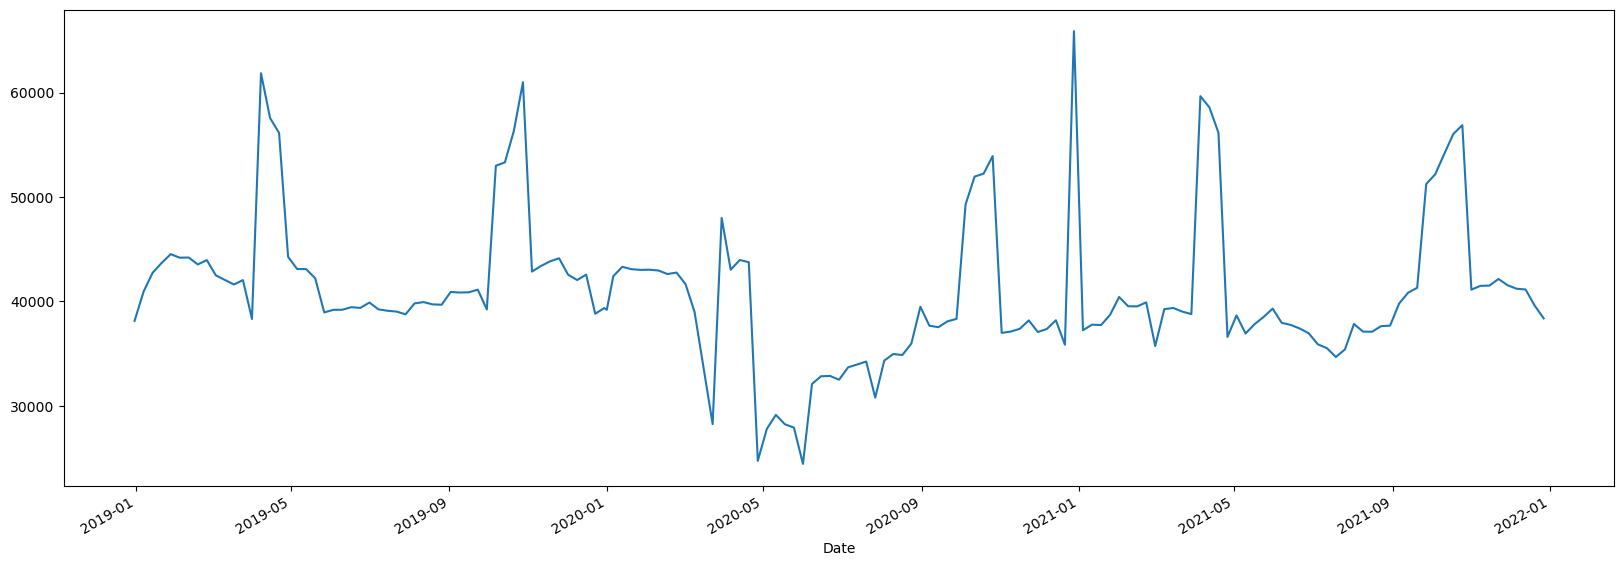

In [26]:
df_train.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

In [27]:
avg_emission_non_virus = df_train[df_train['year'].isin((2019,2021))].groupby('week_no')['emission'].mean()
avg_emission_virus = df_train[df_train['year'] == 2020].groupby('week_no')['emission'].mean()

ratios_for_weeks = avg_emission_non_virus/avg_emission_virus

df_train.loc[df_train['year'] == 2020, 'emission'] *= df_train['week_no'].map(ratios_for_weeks)

<Axes: xlabel='Date'>

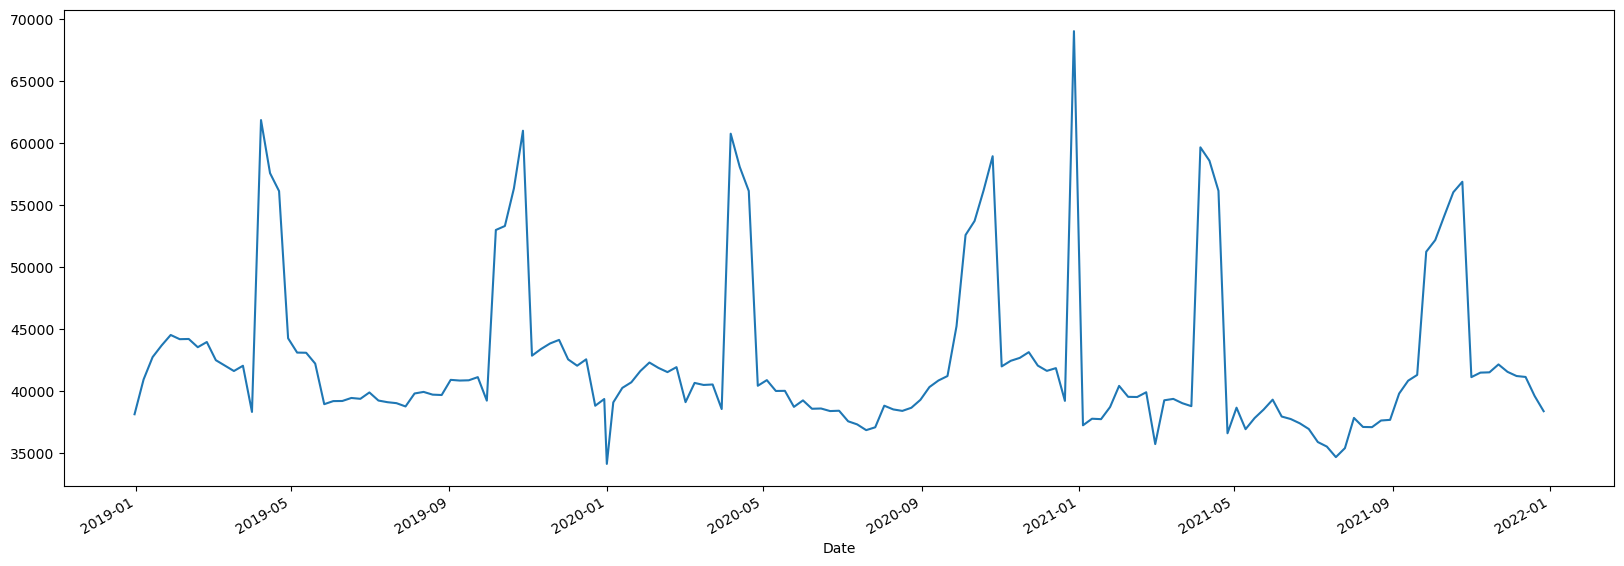

In [28]:
df_train.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

In [29]:
df_train.loc[(df_train['week_no'] == 52) & (df_train['year'] == 2020), 'emission'] = np.power(df_train.loc[(df_train['week_no'] == 52) & (df_train['year'] == 2020), 'emission'], 1/1.5)

<Axes: xlabel='Date'>

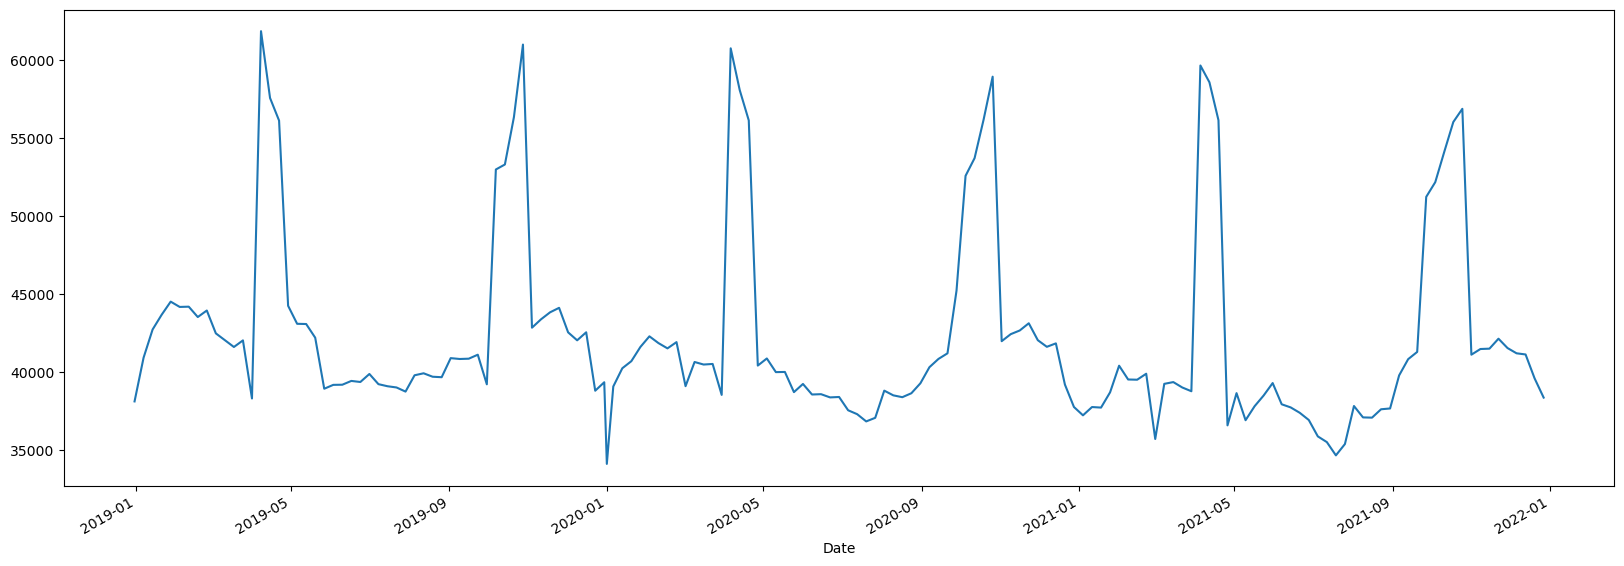

In [30]:
df_train.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

In [31]:
def create_date_features(df):
    df['holidays'] = (df['week_no'].isin([0, 51, 12, 30]))

    df['week_sin'] = np.sin(2 * np.pi * df['week_no']/53)
    df['week_cos'] = np.cos(2 * np.pi * df['week_no']/53)
    
    return df

df_train = create_date_features(df_train)
df_test = create_date_features(df_test)

### Create X and y

In [32]:
X = df_train.drop(columns=['ID_LAT_LON_YEAR_WEEK', 'emission'], axis=1)
y = df_train['emission']

### Normalize data

In [33]:
transfomer = QuantileTransformer(output_distribution='normal', random_state=42)

quantitive_features_train = X.select_dtypes(include=['float64', 'int64'])
normalized_features_train = transfomer.fit_transform(quantitive_features_train)
X = pd.DataFrame(normalized_features_train, columns=quantitive_features_train.columns)


quantitive_features_test = df_test.select_dtypes(include=['float64', 'int64'])
normalized_features_test = transfomer.transform(quantitive_features_test)
df_test = pd.DataFrame(normalized_features_test, columns=quantitive_features_test.columns)

### Scale features

In [34]:
scaler = MinMaxScaler()

quantitive_features_train = X.select_dtypes(include=['float64', 'int64'])
scaled_features_train = scaler.fit_transform(quantitive_features_train)
X = pd.DataFrame(scaled_features_train, columns=quantitive_features_train.columns)


quantitive_features_test = df_test.select_dtypes(include=['float64', 'int64'])
scaled_features_test = scaler.transform(quantitive_features_test)
df_test = pd.DataFrame(scaled_features_test, columns=quantitive_features_test.columns)

In [35]:
X.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,...,UvAerosolIndex_sensor_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,week_sin,week_cos
0,1.0,0.436569,0.0,0.000000,0.412150,0.353760,0.642481,0.396923,0.597677,0.397056,...,0.438545,0.437553,0.385923,0.508709,0.508181,0.368684,0.504978,0.497247,0.499517,1.000000
1,1.0,0.436569,0.0,0.314745,0.473714,0.434000,0.442865,0.554027,0.530588,0.338691,...,0.562982,0.461417,0.400292,0.316745,0.612287,0.368109,0.410052,0.464441,0.508577,0.659548
2,1.0,0.436569,0.0,0.338012,0.675788,0.445728,0.418081,0.591873,0.612442,0.252492,...,0.506145,0.471755,0.444567,0.513650,0.532904,0.408632,0.548839,0.453219,0.517346,0.637372
3,1.0,0.436569,0.0,0.354822,0.498793,0.501207,0.499759,0.499759,0.500362,0.502293,...,0.392333,0.449543,0.381594,0.605437,0.404924,0.476168,0.503235,0.475189,0.526262,0.620495
4,1.0,0.436569,0.0,0.367472,0.425754,0.403773,0.431681,0.537340,0.465658,0.360941,...,0.521451,0.484328,0.505605,0.336829,0.573605,0.391496,0.398772,0.421337,0.536056,0.603184


In [36]:
df_test.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,...,UvAerosolIndex_sensor_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,week_sin,week_cos
0,1.0,0.436569,1.0,0.000000,0.467258,0.454440,0.451931,0.556013,0.476342,0.531852,...,0.378653,0.377605,0.434380,0.458131,0.304141,0.693523,0.394969,0.432159,0.499517,1.000000
1,1.0,0.436569,1.0,0.314745,0.667350,0.412665,0.000000,0.691392,0.352693,0.340286,...,0.404724,0.385661,0.485392,0.471881,0.451622,0.560339,0.456479,0.544981,0.508577,0.659548
2,1.0,0.436569,1.0,0.338012,0.581402,0.355325,0.385242,0.432046,0.534683,0.363373,...,0.534868,0.376767,0.399785,0.400624,0.279188,0.721769,0.446165,0.485673,0.517346,0.637372
3,1.0,0.436569,1.0,0.354822,0.644797,0.415847,0.567121,0.582505,0.653604,0.233008,...,0.539194,0.371332,0.468753,0.556763,0.478430,0.529403,0.460896,0.569389,0.526262,0.620495
4,1.0,0.436569,1.0,0.367472,0.328561,0.340353,0.570896,0.689722,0.352903,0.370199,...,0.336851,0.391239,0.523500,0.537802,0.429013,0.585233,0.477078,0.525201,0.536056,0.603184


### Modeling

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
ridge = Ridge(random_state=42)

params = {'alpha': [2.484497962548759], 'max_iter': [100], 'tol': [0.001]}

grid_ridge = GridSearchCV(ridge, params, cv=5, n_jobs=-1)
grid_ridge.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GridSearchCV(cv=5, estimator=Ridge(random_state=42), n_jobs=-1,
             param_grid={'alpha': [2.484497962548759], 'max_iter': [100],
                         'tol': [0.001]})

In [39]:
best_ridge = grid_ridge.best_estimator_

preds = best_ridge.predict(X_valid)
ridge_score = mean_squared_error(y_valid, preds, squared=False)
ridge_score

138.0358359557279

In [40]:
eli5.show_weights(best_ridge, top=-1, feature_names = X_train.columns.tolist())

Weight?,Feature
+179.838,longitude
+159.715,<BIAS>
+113.754,Cloud_surface_albedo
+63.103,Formaldehyde_tropospheric_HCHO_column_number_density_amf
+53.943,CarbonMonoxide_sensor_altitude
+48.045,NitrogenDioxide_sensor_altitude
+39.904,Ozone_O3_column_number_density
+38.199,NitrogenDioxide_cloud_fraction
+32.477,NitrogenDioxide_NO2_column_number_density
+30.922,latitude


In [41]:
lasso = Ridge(random_state=42)

params = {'alpha': [3.506322726271621], 'max_iter': [100], 'tol': [0.001]}

grid_lasso = GridSearchCV(lasso, params, cv=5, n_jobs=-1)
grid_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(random_state=42), n_jobs=-1,
             param_grid={'alpha': [3.506322726271621], 'max_iter': [100],
                         'tol': [0.001]})

In [42]:
best_lasso = grid_lasso.best_estimator_

preds = best_lasso.predict(X_valid)
lasso_score = mean_squared_error(y_valid, preds, squared=False)
lasso_score

138.0347354485677

In [43]:
eli5.show_weights(best_lasso, top=-1, feature_names = X_train.columns.tolist())

Weight?,Feature
+179.344,longitude
+155.424,<BIAS>
+113.115,Cloud_surface_albedo
+62.672,Formaldehyde_tropospheric_HCHO_column_number_density_amf
+52.628,CarbonMonoxide_sensor_altitude
+48.184,NitrogenDioxide_sensor_altitude
+40.052,Ozone_O3_column_number_density
+38.070,NitrogenDioxide_cloud_fraction
+32.199,NitrogenDioxide_NO2_column_number_density
+30.313,latitude


In [44]:
rf = RandomForestRegressor(n_jobs=1, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=1, random_state=42)

In [45]:
preds = rf.predict(X_valid)
rf_score = mean_squared_error(y_valid, preds, squared=False)
rf_score

22.836059726249065

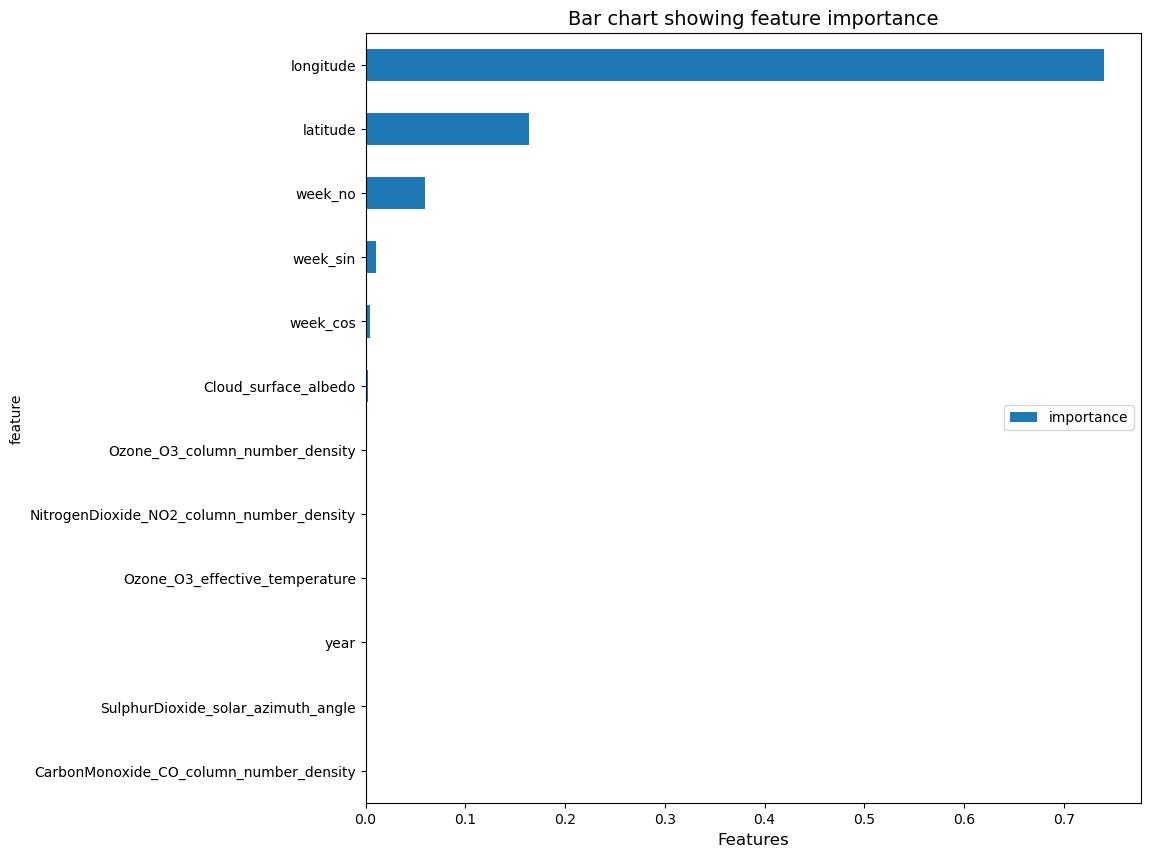

In [46]:
# From https://www.kaggle.com/code/inversion/getting-started-modeling#2.-Feature-engineering
impo_df = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

### Submit

In [47]:
test_pred = rf.predict(df_test)

In [48]:
submission = pd.DataFrame(
    {
        "ID_LAT_LON_YEAR_WEEK": test_idxs,
        "emission": test_pred
    }
)

submission

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,3.864095
1,ID_-0.510_29.290_2022_01,4.157861
2,ID_-0.510_29.290_2022_02,4.166709
3,ID_-0.510_29.290_2022_03,4.255581
4,ID_-0.510_29.290_2022_04,4.253370
...,...,...
24348,ID_-3.299_30.301_2022_44,29.448400
24349,ID_-3.299_30.301_2022_45,28.855573
24350,ID_-3.299_30.301_2022_46,29.193192
24351,ID_-3.299_30.301_2022_47,29.422417


In [49]:
submission.to_csv("submission.csv", index=False)

# TODO

1. Handle target feature distribution 
2. Introduce new features using latitude, longitude and year (also make them as categorical features)
3. Try diffirent feature selection techniques except correlation
4. New models with hyper-parameter tunning
5. Time series (EDA + new features)